# Diffusion 

Original Diffusion Paper: https://arxiv.org/abs/2112.10752

In [158]:
# Imports
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

## Forward diffusion equation

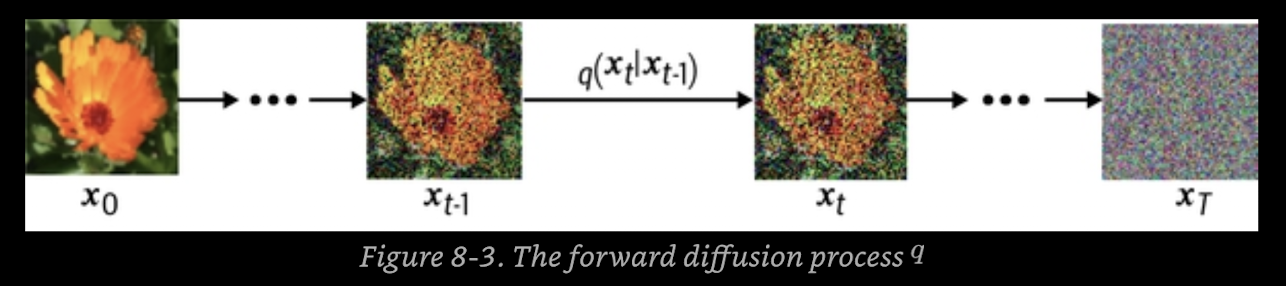

In [159]:
Image(filename='../images/forward_diffusion_flower.png', width=1000)

$$
X_t = \sqrt{1 - \beta_t}X_{t-1} + \sqrt{\beta_t }\epsilon_{t-1}
$$

Images
- X_{t-1} is the image in Figure 8-3, X_{t} is the next image. these are 2D arrays/rank-2 tensor (for grayscale images) or 3D tensor/rank-3 tensor (for color image)

Beta
- the beta value is always between 0 and 1 and determines how much noise to apply at each step
- sqrt(1 - beta) is always < 1, so it is basically making every pixel value smaller (since [0, 0, 0] is black and [255, 255, 255] is white, this  is pusher it closer to black)
- then adding sqrt(beta) * epsilon will introduce the "noise"

Epsilon
- epsilon is a "sampling" of the normal distribution in the form of a rank-3 tensor to match X_{t-1}
- see below code example fo rthe process

QS:
- the pixel values are [0, 0, 0] to [255, 255, 255] how does \sqrt{\beta_t }\epsilon_{t-1} prevent pushing X_t to have values beyond 255 or below 0?
- why is the first square root of Beta 1-Beta but the second is something else?
- if X_t is a rank-3 tensor, then what is epsilon? a rank-3 tensor? something else? what are its values?
- what does "variance" mean simplified?
- what is Beta for? why is it here?
- what does the graph of epsilon look like? plot it out in python
- whats the value of Bt? how do I choose it?

### Epsilon Example

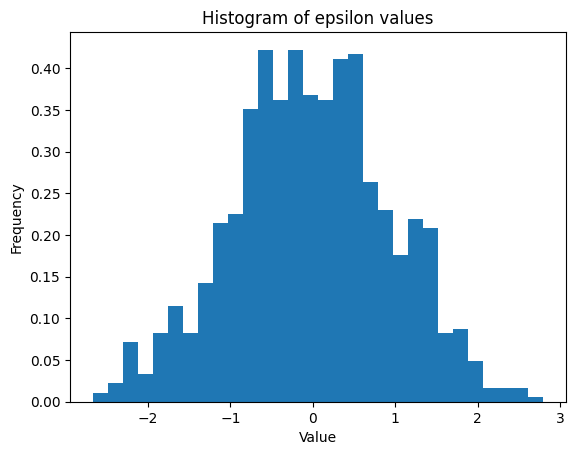

In [160]:
# Plot of a normal distribution (standard gaussian)

# Sample epsilon from a standard normal distribution
epsilon = np.random.normal(0, 1, 1000)

# Plot the histogram of epsilon values
plt.hist(epsilon, bins=30, density=True)
plt.title('Histogram of epsilon values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

### 3-d tensor values

In [161]:
# Set a seed for reproducibility
np.random.seed(0)

# Create a smaller 5x5x3 array for demonstration
image_height, image_width, color_channels = 5, 5, 3
epsilon_small = np.random.normal(0, 1, (image_height, image_width, color_channels))

# Round to 1 decimal place for readability
epsilon_small = np.round(epsilon_small, 1)

print(f"Array shape: {epsilon_small.shape}")
print("\nArray structure:")
print("[ # Outer list (height)")
for i in range(image_height):
    if i == 0:
        print("  [ # Inner list (width)")
    else:
        print("  [")
    for j in range(image_width):
        pixel = epsilon_small[i, j]
        print(f"    [{pixel[0]:.1f}, {pixel[1]:.1f}, {pixel[2]:.1f}], # RGB values for pixel ({i},{j})")
    if i == image_height - 1:
        print("  ] # End of inner list")
    else:
        print("  ],")
print("] # End of outer list")

print("\nAccessing a single pixel:")
x, y = 2, 2
pixel = epsilon_small[x, y]
print(f"Pixel at position (2, 2): [R: {pixel[0]:.1f}, G: {pixel[1]:.1f}, B: {pixel[2]:.1f}]")

print("\nFull array shape information:")
print(f"Height (rows): {epsilon_small.shape[0]}")
print(f"Width (columns): {epsilon_small.shape[1]}")
print(f"Color channels: {epsilon_small.shape[2]}")
print(f"Total number of elements: {epsilon_small.size}")

Array shape: (5, 5, 3)

Array structure:
[ # Outer list (height)
  [ # Inner list (width)
    [1.8, 0.4, 1.0], # RGB values for pixel (0,0)
    [2.2, 1.9, -1.0], # RGB values for pixel (0,1)
    [1.0, -0.2, -0.1], # RGB values for pixel (0,2)
    [0.4, 0.1, 1.5], # RGB values for pixel (0,3)
    [0.8, 0.1, 0.4], # RGB values for pixel (0,4)
  ],
  [
    [0.3, 1.5, -0.2], # RGB values for pixel (1,0)
    [0.3, -0.9, -2.6], # RGB values for pixel (1,1)
    [0.7, 0.9, -0.7], # RGB values for pixel (1,2)
    [2.3, -1.5, 0.0], # RGB values for pixel (1,3)
    [-0.2, 1.5, 1.5], # RGB values for pixel (1,4)
  ],
  [
    [0.2, 0.4, -0.9], # RGB values for pixel (2,0)
    [-2.0, -0.3, 0.2], # RGB values for pixel (2,1)
    [1.2, 1.2, -0.4], # RGB values for pixel (2,2)
    [-0.3, -1.0, -1.4], # RGB values for pixel (2,3)
    [-1.7, 2.0, -0.5], # RGB values for pixel (2,4)
  ],
  [
    [-0.4, -1.3, 0.8], # RGB values for pixel (3,0)
    [-1.6, -0.2, -0.9], # RGB values for pixel (3,1)
    [0.4, 

### Showing the noise process with the formula

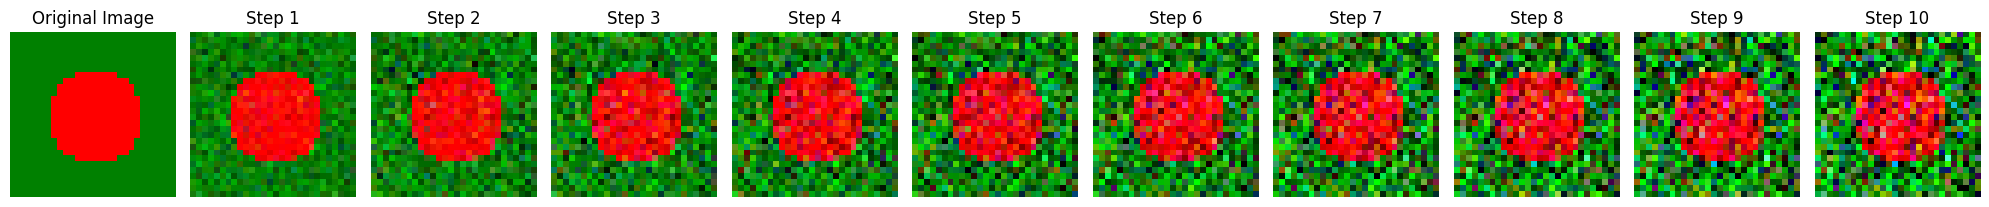

In [162]:
# Configuration (defaults)
image_height = 28
image_width = 28
color_channels = 3  # RGB
background_color = [0, 128, 0]  # Green background
apple_color = [255, 0, 0]  # Red color for the apple
center_x, center_y = image_height // 2, image_width // 2
radius = 8  # Radius of the apple

# Configuration (changeable)
num_steps = 10  # Number of diffusion steps
betas = np.linspace(0.0001, 0.1, num_steps)  # linspace will create a range of betas of length num_of_steps evenly spaced from .0001 to .1

# Create a green background
sample_image = np.full((image_height, image_width, color_channels), background_color, dtype=np.float32)

# Draw a red circle in the middle to represent an apple
for y in range(image_height):
    for x in range(image_width):
        if (x - center_x) ** 2 + (y - center_y) ** 2 < radius ** 2:
            sample_image[y, x, :] = apple_color

# Normalize the image to 0-1 range
sample_image = sample_image / 255.0

# Display the original image
plt.figure(figsize=(20, 4))
plt.subplot(1, num_steps + 1, 1)
plt.title('Original Image')
plt.imshow(np.clip(sample_image, 0, 1)) # fyi, clip isn't important in the noise creation
plt.axis('off')

# Apply the noise process through num_steps steps
noisy_image = sample_image.copy()
for step in range(num_steps):
    beta = 0.01 # betas[step] # you can try this with betas changing at each step or beta remaining the same at each step
    epsilon = np.random.normal(0, 1, (image_height, image_width, color_channels))
    noisy_image = np.sqrt(1 - beta) * noisy_image + np.sqrt(beta) * epsilon # IMPORTANT: this is the same formula as the above
    
    # Display each step
    plt.subplot(1, num_steps + 1, step + 2)
    plt.title(f'Step {step + 1}')
    plt.imshow(np.clip(noisy_image, 0, 1)) # fyi, clip isn't important in the noise creation
    plt.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Another form of the forward diffusion equation

Same formula new tricks

$$
q(x_t | x_{t-1}) = \mathcal{N}(x_{t-1}; \sqrt{1 - \beta_t}x_{t-1}, \beta_t I)
$$

N
- N is the function for the normal distribution (standard gaussian)
- For a single variable normal distribution, N(0,1) means a normal distribution with mean of 0 and standard deviation of 1
- N here is a multivariable normal distribution which is N(x; m, cov) where m = mean, cov = covariance matrix

q()
- q(x_t | x_{t-1}) is equivalent to xt function above but instead of having a single image xt it is a distribution
- you pull any item out of the distribution q(...) and it will give you a single xt
- this is equivalent to the original because epsilon is also a normal distribution, on different runs xt change change if you sampled from a different point in epsilons distribution


QS:
- what is a covariance matrix?
- what does the plot of N look like? how does beta etc affect how it looks?
- how do you plot a distribution of tensors/matrices? or how do i visualize this?
- how do you transform the first equation to this second one here?

## Another form of the forward diffusion equation

Same formula but this one allows
$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\alpha_t} x_0, (1 - \alpha_t) I)
$$

Qs:
- how do you transform the first or second equation into this new one here?

## Diffusion schedules

Just different ways to choose the values for b_t at each step of introducing noise to the image (step t)

## Reverse Diffusion Process

Now we want to find 

$$
q(x_t | x_{t-1})
$$

- notice the reverse of the x's we want to find a way to "de-noise" a noisy image produced from forward diffusion

$$
x_{t-1} = \sqrt{\alpha_{t-1}} \left( \frac{x_t - \sqrt{1 - \bar{\alpha}_t} \epsilon_{\theta}^{(t)}(x_t)}{\sqrt{\bar{\alpha}_t}} \right) + \sqrt{1 - \bar{\alpha}_{t-1} - \sigma_t^2} \cdot \epsilon_{\theta}^{(t)}(x_t) + \sigma_t \epsilon_t
$$